In [38]:
# CS180 (CS280A): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.transform
import skimage.io as skio

In [282]:
# name of the input file
imname = 'data/statue.tif'

# read in the image
im = skio.imread(imname)

# convert to double (might want to do this later on to save memory)
im = sk.img_as_float(im)

# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2 * height]
r = im[2 * height: 3 * height]

Naive, no alignment


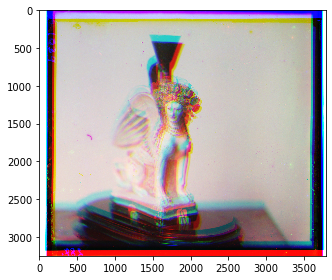

In [283]:
def naive():
    # create a color image
    im_out = np.dstack([r, g, b])

    # display the image
    skio.imshow(im_out)
    skio.show()
print("Naive, no alignment")
naive()

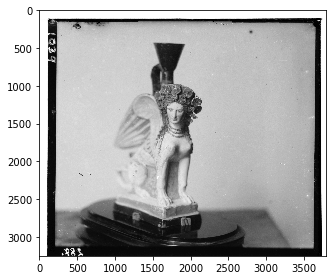

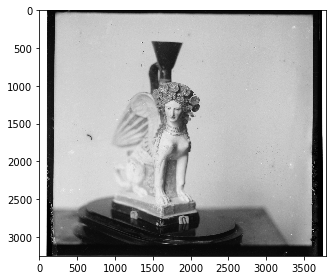

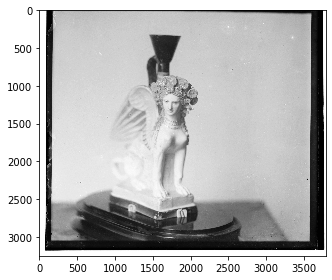

In [284]:
# Display the grayscale images
def grayscale(color):
    gray = np.repeat(color.reshape(color.shape[0], -1, 1), 3, axis=-1)
    skio.imshow(gray)
    skio.show()

grayscale(b)
grayscale(g)
grayscale(r)

In [285]:
r.shape

(3250, 3788)

In [286]:
import time
def convolve(img, kernel):
    #sliding_window = numpy.lib.stride_tricks.sliding_window_view(img.shape, (3,3))
    sliding_window = np.lib.stride_tricks.sliding_window_view(img, (3,3))
    convolved = np.multiply(sliding_window, kernel)
    return convolved.sum(axis=(-2, -1))

In [287]:
def align(c, b, metric="euclidean", scale="single", border = 5, depth=5):    
    '''
    Aligns image c to image b using the metric. Allows two types of scaling, 'single' and 'pyramid'.
    border is the number of pixels we will ignore on all sides of each image.
    '''
    if scale == "pyramid" and depth > 0:
        rescaled_c = sk.transform.rescale(c, 0.5)
        rescaled_b = sk.transform.rescale(b, 0.5)
        _, start_search = align(rescaled_c, rescaled_b, metric=metric, scale=scale, border=border//2, depth=depth-1)
        start_search = [start_search[0]*2, start_search[1]*2]
    else:
        start_search = [0, 0]
    
    vertical_kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    horizontal_kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    # Aligns image c to b
    c_og = c # The original c. We save it for later
    if metric == "ncc":
        b = b/np.linalg.norm(b)
        c_shift = np.linalg.norm(c_og)
        c = c/cnorm
    elif metric == "vertical":
        b = convolve(b, vertical_kernel)
        c = convolve(c_og, vertical_kernel)
    elif metric == "horizontal":
        b = convolve(b, horizontal_kernel)
        c = convolve(c_og, horizontal_kernel)
    elif metric == "edges": # Both vertical and horizontal
        b = convolve(b, horizontal_kernel)**2 + convolve(b, vertical_kernel)**2
        c = convolve(c_og, horizontal_kernel)**2 + convolve(c, vertical_kernel)**2
    
    b = b[border:-border, border:-border]
    c = c[border:-border, border:-border]
    score = float('inf') # Alignment score. Lower is better
    best_shift = None
    
    width = 15 if scale == "single" else 5 # The width of the square we search in
    
    for xshift in np.arange(-width + start_search[0], width + start_search[0]):
        for yshift in np.arange(-width + start_search[1], width + start_search[1]):
            shifted = np.roll(c, (xshift, yshift), axis=(0, 1))
            
            if metric == "ncc":
                s = np.dot(shifted.T, b).sum()
            else:
                s = ((b - shifted)**2).sum()
            if s < score:
                score = s
                best_shift = [xshift, yshift]
    best_shifted = np.roll(c_og, (best_shift[0], best_shift[1]), axis=(0, 1)) # Shift the original c by our best shift
    return best_shifted, best_shift

In [288]:
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)

# Align, and print out the shifted grayscales
metric = "edges"
scale = "pyramid" if "tif" in imname else "single" # Only do pyramid if it is a tif file
border = b.shape[0]//6
ag, shiftg = align(g, b, metric=metric, scale=scale, border=border, depth=5)
ar, shiftr = align(r, b, metric=metric, scale=scale, border=border, depth=5)

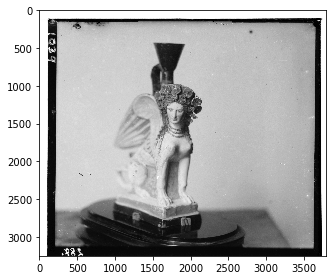

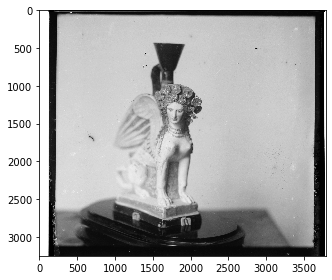

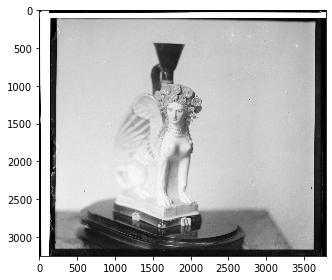

In [289]:
# Prints out the shifted channels as grayscale
grayscale(b)
grayscale(ag)
grayscale(ar)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


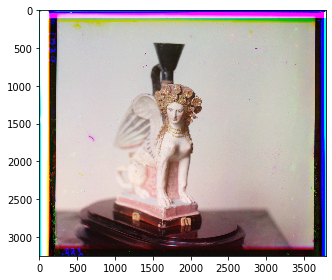

In [290]:
# create a color image
im_out = np.dstack([ar, ag, b])
# save the image
fname = "out/" + imname[5:-3] + "jpg"
skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()

In [291]:
print("G Offset:", shiftg)
print("R Offset:", shiftr)

G Offset: [21, 27]
R Offset: [110, 53]
